In [24]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from utils.Dataset import load_logging_data
from utils.layer import DecompositionLayer
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.sysconfig.get_build_info())
print(tf.config.list_physical_devices('GPU'))

True
OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_dataset = load_logging_data(data_root_path='data/train')
val_dataset = load_logging_data(data_root_path='data/val')

train_dataset['Data_Type'] = 'train'
val_dataset['Data_Type'] = 'validation'

data = pd.concat([train_dataset, val_dataset], axis=0)
data.reset_index(drop=True, inplace=True)

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
angle_name_list = list(data.columns)[22:24] + list(data.columns)[26:28]
pressure_name_list = list(data.columns)[18:20] + list(data.columns)[24:26]

new_angle_name_list = ['Mast_X(deg)', 'Mast_Y(deg)', 'Base_X(deg)', 'Base_Y(deg)']
new_pressure_name_list = ['P1(bar)', 'P2(bar)', 'P3(bar)', 'P4(bar)']

data.rename(columns={'Time  1 - default sample rate': 'Time(sec)'}, inplace=True)
data.rename(columns={'caloutput_drill_depth CH=26': 'Drill_Depth(m)'}, inplace=True)
data.rename(columns={'caloutput_rotate_velocity CH=25': 'Drill_Rotation(RPM)'}, inplace=True)

for angle_name, new_angle_name in zip(angle_name_list, new_angle_name_list):
    data.rename(columns={angle_name: new_angle_name}, inplace=True)

for pressure_name, new_pressure_name in zip(pressure_name_list, new_pressure_name_list):
    data.rename(columns={pressure_name: new_pressure_name}, inplace=True)

data[new_pressure_name_list[3]] = np.clip(data[new_pressure_name_list[3]].to_numpy(), 0, 300)
data['Work_Load'] = (data[new_pressure_name_list[3]] * (data['Drill_Rotation(RPM)']))
data['Drill_Depth(m)'] = data['Drill_Depth(m)']/10

for angle_name in new_angle_name_list:
    data[angle_name] = data[angle_name].clip(lower=-3, upper=3)

data['Work_Load'] = data['Work_Load']/1100
data['Work_Load'] = data['Work_Load']*100

feature_name_list = new_angle_name_list + [new_pressure_name_list[3]] + ['Drill_Rotation(RPM)']

target_name = 'Work_Load_Cls'
bool_arr = data['Work_Load'].to_numpy() >= 60
bool_arr = bool_arr.astype(np.int32)

data = pd.concat([data, pd.DataFrame(bool_arr, columns=[target_name])], axis=1)

dataset = data[feature_name_list+[target_name]]

dataset

,Mast_X(deg),Mast_Y(deg),Base_X(deg),Base_Y(deg),P4(bar),Drill_Rotation(RPM),Work_Load_Cls
0,-3.0,-3.0,-3.0,-3.0,7.150,0.0,0
1,0.2,-0.4,-0.6,0.0,7.150,0.0,0
2,0.2,-0.4,-0.6,0.0,7.150,0.0,0
3,0.3,-0.4,-0.6,0.0,7.825,0.0,0
4,0.3,-0.4,-0.6,0.0,7.825,0.0,0
...,...,...,...,...,...,...,...
21369,0.2,-0.3,-0.6,-0.6,11.880,0.0,0
21370,0.2,-0.4,-0.6,-0.6,11.880,0.0,0
21371,0.2,-0.4,-0.6,-0.6,12.580,0.0,0
21372,0.2,-0.3,-0.6,-0.6,12.580,0.0,0


In [5]:
dataset_arr = dataset.to_numpy()
seq_len = 30
pred_distance = 25

val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=dataset_arr,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=dataset_arr.shape[1]-1)
val_target = np.squeeze(val_target)

print(val_feature.shape, val_target.shape)
print((val_feature.itemsize*val_feature.size)/(1024**2))
print((val_target.itemsize*val_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/21349 [00:00<?, ?it/s]

(21320, 30, 6) (21320,)
29.278564453125
0.16265869140625


In [8]:
model = keras.models.load_model(f'models/model_{pred_distance}.keras', custom_objects={'DecompositionLayer': DecompositionLayer})

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 6)]      0           []                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 30)          0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 30)          0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

In [9]:
val_pred = model.predict(val_feature, verbose=1)
val_pred = np.squeeze(val_pred)

667/667 [==============================] - 18s 17ms/step


In [10]:
val_target_string = []

for val in val_target:
    if val == 1:
        val_target_string.append('High Load')
    else:
        val_target_string.append('Normal Load')

result_df = pd.concat([pd.DataFrame(val_pred, columns=['prediction']),
                       pd.DataFrame(val_target_string, columns=['target'])], axis=1)

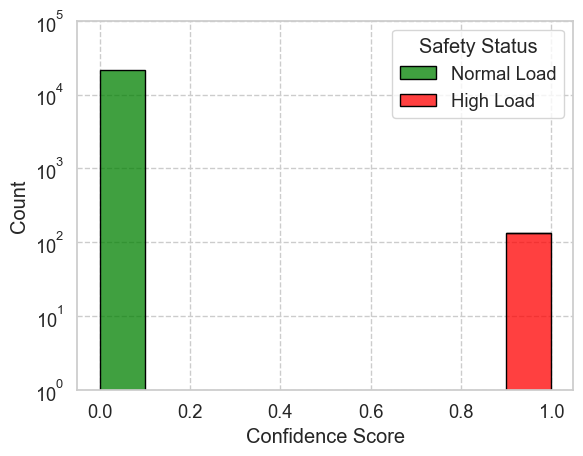

In [22]:
sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

custom_color = {'High Load': 'red', 'Normal Load': 'green'}

ax = sns.histplot(data=result_df, x='prediction', hue='target', bins=10, multiple='stack', edgecolor='black', palette=custom_color)

plt.xlabel('Confidence Score')
plt.ylim(1, 100000)
plt.yscale('log')

ax.legend_.set_title('Safety Status')

Best Threshold: 0.010
Best F1 Score: 1.0000


Text(0, 0.5, 'Score')

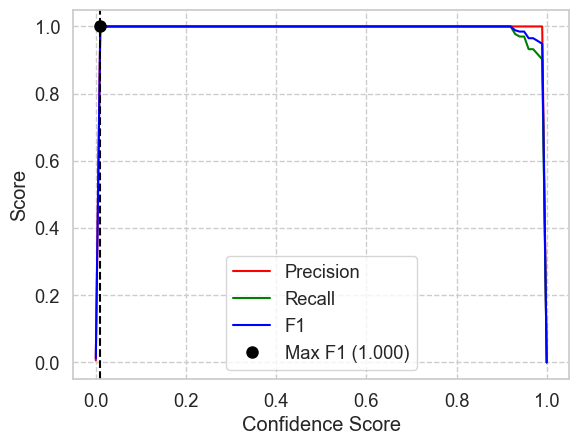

In [25]:
thr_val_arr = np.arange(0.0, 1.01, 0.01)

precision_arr = []
recall_arr = []
f1_arr = []

for thr_val in thr_val_arr:
    val_pred_binary = np.where(val_pred > thr_val, 1, 0)
    precision = precision_score(val_target, val_pred_binary, zero_division=0)
    recall = recall_score(val_target, val_pred_binary, zero_division=0)
    f1 = f1_score(val_target, val_pred_binary, zero_division=0)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)

precision_arr = np.array(precision_arr)
recall_arr = np.array(recall_arr)
f1_arr = np.array(f1_arr)

sns.set_theme(font_scale=1.2)
sns.set_style('whitegrid', {'grid.linestyle': '--'})

sns.lineplot(x=thr_val_arr, y=precision_arr, color='red', label='Precision')
sns.lineplot(x=thr_val_arr, y=recall_arr, color='green', label='Recall')
sns.lineplot(x=thr_val_arr, y=f1_arr, color='blue', label='F1')

best_f1_index = np.argmax(f1_arr)

best_threshold = thr_val_arr[best_f1_index]
best_f1_score = f1_arr[best_f1_index]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

plt.axvline(x=best_threshold, color='black', linestyle='--')
plt.plot(best_threshold, best_f1_score, 'o', color='black', markersize=8,
         markeredgecolor='black', label=f'Max F1 ({best_f1_score:.3f})')

plt.legend()

plt.xlabel('Confidence Score')
plt.ylabel('Score')

([<matplotlib.axis.YTick at 0x2550a489570>,
 [Text(0, 0.5, 'Safe(0)'), Text(0, 1.5, 'Unsafe(1)')])

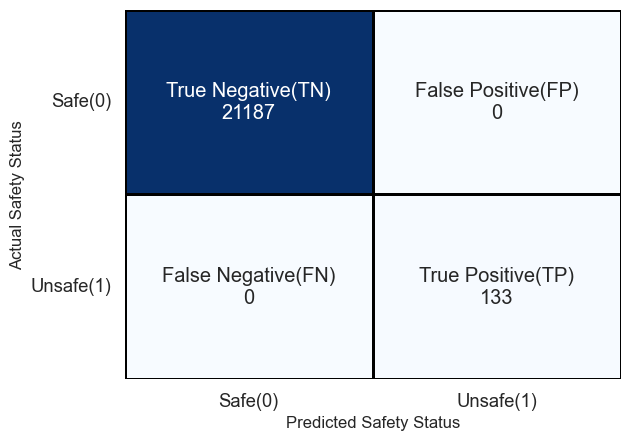

In [26]:
val_pred_binary = np.where(val_pred > best_threshold, 1, 0)

cm = confusion_matrix(val_target, val_pred_binary)

labels = np.array([[f'True Negative(TN)\n{cm[0, 0]}', f'False Positive(FP)\n{cm[0, 1]}'],
                   [f'False Negative(FN)\n{cm[1, 0]}', f'True Positive(TP)\n{cm[1, 1]}']])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linecolor='black', linewidths=1)

plt.ylabel('Actual Safety Status', fontsize=12)
plt.xlabel('Predicted Safety Status', fontsize=12)

plt.xticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'])
plt.yticks([0.5, 1.5], ['Safe(0)', 'Unsafe(1)'], rotation=0, va='center')

In [27]:
print(precision_score(val_target, val_pred_binary))
print(recall_score(val_target, val_pred_binary))
print(f1_score(val_target, val_pred_binary))

1.0
1.0
1.0


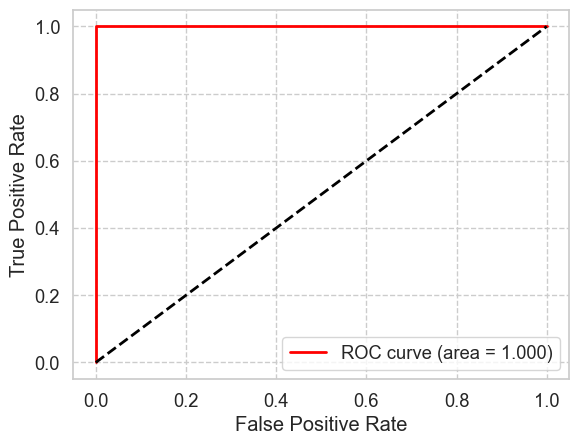

In [28]:
auc = roc_auc_score(y_true=val_target, y_score=val_pred)
fpr, tpr, thresholds = roc_curve(y_true=val_target, y_score=val_pred)

plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)